In [1]:
import matplotlib.pyplot as plt
import numpy as np

from dataset import sample_by_quantiles, sample_iid
from load import read_csv

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["cm"],
})


In [3]:
datapath = './Data/data.csv'
data = read_csv(datapath).sample(frac=0.1)
print(data.shape)
data = data.drop(columns='PATIENTID')

(4002, 42)


In [4]:
cols_standardise = ['GRADE', 'AGE', 'QUINTILE_2015', 'NORMALISED_HEIGHT', 'NORMALISED_WEIGHT']
cols_minmax = ['SEX', 'TUMOUR_COUNT', 'REGIMEN_COUNT']
cols_leave = ['SACT', 'CLINICAL_TRIAL_INDICATOR', 'CHEMO_RADIATION_INDICATOR','BENIGN_BEHAVIOUR','SITE_C70', 'SITE_C71', 'SITE_C72', 'SITE_D32','SITE_D33','SITE_D35','CREG_L0201','CREG_L0301','CREG_L0401','CREG_L0801','CREG_L0901','CREG_L1001','CREG_L1201','CREG_L1701','LAT_9','LAT_B','LAT_L','LAT_M','LAT_R','ETH_A','ETH_B','ETH_C','ETH_M','ETH_O','ETH_U','ETH_W','DAYS_TO_FIRST_SURGERY']

all_cols = cols_standardise + cols_minmax + cols_leave

print(len(data.columns) == len(cols_standardise + cols_minmax + cols_leave) + 2)

standardise = [([col], StandardScaler()) for col in cols_standardise]
minmax = [([col], MinMaxScaler()) for col in cols_minmax]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardise + minmax + leave)

features = x_mapper.fit_transform(data).astype('float32')

True


In [5]:
labels = (data.DAYS_SINCE_DIAGNOSIS.values, data.EVENT.values)

In [6]:
# dict_center_idxs = sample_iid(features, 4)
dict_center_idxs = sample_by_quantiles(labels, 0, 4)

In [7]:
def rand_jitter(applyto, arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


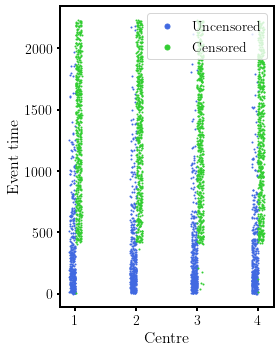

In [8]:
categories = list('1234')
fig, ax = plt.subplots(figsize=(4,5))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
colors = ["royalblue",'limegreen']
dotsize = 1
marker = 'o'
for center, idxs in enumerate(dict_center_idxs.values()):
    durations = labels[0][list(idxs)]
    events = labels[1][list(idxs)]

    uncensored = durations[np.where(events == 1)]
    censored = durations[np.where(events == 0)]

    width = 0.1
    x = np.ones(len(uncensored)) * center - width/2 + (np.random.rand(len(uncensored))*width-width/2.)
    if center == 0:
        ax.scatter(x, uncensored, marker=marker,s=dotsize, color=colors[0], label='Uncensored')
    else:
        ax.scatter(x, uncensored, marker=marker,s=dotsize, color=colors[0])
    x = np.ones(len(censored)) * center + width/2 + (np.random.rand(len(censored))*width-width/2.)
    if center == 0:
        ax.scatter(x, censored, marker=marker,s=dotsize, color=colors[1], label='Censored')
    else:
        ax.scatter(x, censored, marker=marker,s=dotsize, color=colors[1])
    ax.legend(fontsize=14, markerscale=5)

ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, fontsize=14)
ax.tick_params(axis='y', labelsize=14)
# ax.set_yticklabels([0,500,1000,1500,2000,2500,3000], fontsize=14)
ax.set_xlabel('Centre', fontsize=16)
ax.set_ylabel('Event time', fontsize=16)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
plt.tight_layout()
plt.savefig('./figs/noniid.eps', format='eps')
